In [185]:
import plotly.express as px
import plotly.graph_objects as go
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import pickle
import datetime
import numpy as np
from dataset.ipc2023_learning_domain_info import IPC2023_LEARNING_DOMAINS, DIFFICULTIES, PROBLEM_INDICES
from itertools import product
from IPython.display import display, HTML
from util.scrape_log import scrape_search_log
from pathlib import Path

In [186]:
_ICAPS_PAPER_DIR=str(Path.home())+"/papers/manuscripts/icaps-24-kernels"
_ICAPS_PLOT_DIR=f"{_ICAPS_PAPER_DIR}/plots"
os.makedirs(_ICAPS_PLOT_DIR, exist_ok=True)
_PLOT_DIRS = [_ICAPS_PLOT_DIR]

pd.options.display.float_format = "{:.1f}".format

In [187]:
## collect logs
# os.system("sh scripts_gnn/collect_cluster1_test.sh")
# os.system("sh scripts_kernel/collect_gadi_test.sh")

In [188]:
BLIND = "blind"
HFF = "hff"

GOOSE_MEAN = "gI4mean"
GOOSE_MAX = "gI4max"

MUNINN = "muninn"
GOOSE_LLG_CPU = "goose-genplan23"
LAMA = "lama-first"

MQ_GPR = "combined_gpr"
MQ_SVR = "combined_svr"
LWL_2 = "2lwl_4_linear-svr_none"
LWL_3 = "3lwl_4_linear-svr_none"
SVR_1 = "1wl_4_linear-svr_none"
SVR_2 = "1wl_4_quadratic-svr_none"
SVR_3 = "1wl_4_cubic-svr_none"
SVR_inf = "1wl_4_rbf-svr_none"
GPR = "1wl_4_gp_none"
MIP = "1wl_4_mip_schema"

_MODELS = [
    BLIND,
    HFF,
    LAMA,
    MUNINN,
    # GOOSE_LLG_CPU,
    #   "gL4max",
    #   "gL4mean",
    GOOSE_MAX,
    GOOSE_MEAN,
    # MQ_GPR,
    # MQ_SVR,
    # MIP,
    GPR,
    SVR_1,
    # SVR_2,
    # SVR_3,
    SVR_inf,
    LWL_2,
    # LWL_3,
]

WLS = {
    MQ_GPR,
    MQ_SVR,
    MIP,
    GPR,
    SVR_1,
    SVR_2,
    SVR_3,
    SVR_inf,
    LWL_2,
    LWL_3,
}
CLASSICAL = {
    BLIND,
    HFF,
    LAMA,
}
GNNS = {
    MUNINN,
    GOOSE_LLG_CPU,
    GOOSE_MAX, 
    GOOSE_MEAN,
    "gI4max",
    "gI4mean",
}

MQ_SKIPPED_DOMAINS = {
    "blocksworld",
    "sokoban",
}

PLOT_MAX_STD = 1e3
PLOT_MAX_EXPANDED = 1e8
PLOT_MAX_COST = 1e4
CUM_SIZE = 26

In [189]:
RENAME = {
    MUNINN: "Muninn",
    "gI4max": "g_max",
    "gI4mean": "g_mean",
    LAMA: "lama",
    GOOSE_LLG_CPU: "gGenPlan23",
    GPR: "gpr",
    MIP: "mip",
    SVR_1: "1svr",
    SVR_2: "2svr",
    SVR_3: "3svr",
    SVR_inf: "∞svr",
    LWL_2: "2lwl",
    LWL_3: "3lwl",
    MQ_SVR: "mq_svr",
    MQ_GPR: "mq_gpr",
}

PLOT_RENAME = {
    "gI4max": "GOOSE(max)",
    "gI4mean": "GOOSE(mean)",
    "hff": r"hFF",
}

LATEX_RENAME = {
    BLIND: r"$\text{blind}$",
    HFF: r"$h^{\text{FF}}$",
    MUNINN: r"$\text{Muninn}$",
    GOOSE_MAX: r"$\text{GNN}_{\text{max}}$",
    GOOSE_MEAN: r"$\text{GNN}_{\text{mean}}$",
    GPR: r"$\text{GPR}$",
    MQ_GPR: r"$\text{GPR+MIP}$",
    MIP: r"$\text{MIP}$",
    SVR_1: r"$\text{SVR}$",
    SVR_2: r"$\text{SVR}_2$",
    SVR_3: r"$\text{SVR}_3$",
    SVR_inf: r"$\text{SVR}_{\inf}$",
    LWL_2: r"$\text{2-LWL}$",
}


def model_type(model):
    if model in GNNS: return "gnn"
    if model in WLS: return "wl" 
    if model in CLASSICAL: return "classical" 
    raise ValueError(model)


def rename(model):
    if model in RENAME:
        return RENAME[model]
    return model


def unrename(model):
    for k, v in RENAME.items():
        if v == model:
            return k
    return model


def plot_rename(model):
    if model in PLOT_RENAME:
        return PLOT_RENAME[model]
    return model

def linestyle(model):
    if model in CLASSICAL:
        return "solid"
    if model in GNNS:
        return "dotted"
    if model in WLS:
        return "dashed"
    
def markerstyle(model):
    if model in CLASSICAL:
        return "o"
    if model in GNNS:
        return "x"
    if model in WLS:
        return "P"

In [190]:
with open("ipc-2023-learning-reference-costs.pkl", 'rb') as file:
    REFERENCE_COSTS = {domain : [] for domain in IPC2023_LEARNING_DOMAINS}
    for (domain, diff_in_int, problem_index), reference_cost in pickle.load(file).items():
        REFERENCE_COSTS[domain].append(reference_cost)
## (domain) -> [reference_costs_1, ..., reference_costs_90]
# REFERENCE_COSTS

In [191]:
""" Preprocess data """


def get_data_tmp(domain):
    data = {}

    for model in _MODELS:
        d = {
            "solved": [],
            "expanded": [],
            "cost": [],
            "first_h": [],
            "std": [],
            "ratio_seen_colours": [],
            "quality": [],
            "c_opt": [],
            "c_opt_min": [],
            "difficulty": [],
            "time": [],
            "tried": [],
        }

        for diff_i, difficulty in enumerate(DIFFICULTIES):
            for prob_i, pf_name in enumerate(PROBLEM_INDICES):
                pf = f"../benchmarks/ipc2023-learning-benchmarks/{domain}/testing/{difficulty}/{pf_name}.pddl"
                assert os.path.exists(pf)
                stats = None
                if model == "muninn":
                    stats = {
                        "first_h": -1,
                        "solved": 0,
                        "time": -1,
                        "cost": -1,
                        "expanded": -1,
                        "evaluated": -1,
                        "tried": 1,
                    }
                    log_file = f"logs/muninn/{domain}_{difficulty}_{pf_name}.log"
                    plan_file = f"logs/muninn/{domain}_{difficulty}_{pf_name}.plan"
                    cost = 0
                    if os.path.exists(plan_file):
                        with open(plan_file, "r") as f:
                            for line in f.readlines():
                                if len(line) > 0 and line[0] == "(":
                                    cost += 1
                    if cost > 0:
                        stats["solved"] = 1
                        stats["cost"] = cost
                    stats["time"] = 0
                    for line in open(log_file, "r").readlines():
                        if "[1]" in line:
                            toks = line.replace(",", "").replace("(", "").replace(")", "").split()
                            stats["first_h"] = float(toks[4])
                            stats["time"] += float(toks[-2]) / 1000
                        # elif "Walltime Used:" in line:
                        #     time_object = datetime.datetime.strptime(line.split()[-1], "%H:%M:%S")
                        #     stats["time"] = time_object.hour * 3600 + time_object.minute * 60 + time_object.second
                elif model == "goose-genplan23":
                    log_file = f"icaps24_test_logs_old/{domain}_{difficulty}_{pf_name}_{model}.log"
                elif model[0] == "g":
                    # gI4max
                    rep = {"I": "ilg", "L": "llg"}[model[1]]
                    L = model[2]
                    aggr = model[3:]
                    log_file = f"icaps24_test_logs_old/{domain}_{difficulty}_{pf_name}_{domain}_{rep}_L{L}_H64_{aggr}_r0.log"
                elif model == MIP and domain in {"blocksworld", "sokoban"}:
                    log_file = f"logs/ipc2023_blind/{domain}_{difficulty}_{pf_name}_blind.log"
                elif model in WLS:
                    desc = None
                    desc_helper = model
                    if model in {MQ_SVR, MQ_GPR} and domain not in MQ_SKIPPED_DOMAINS:
                        desc = model
                    elif model == MQ_SVR and domain in MQ_SKIPPED_DOMAINS:
                        desc_helper = SVR_1
                    elif model == MQ_GPR and domain in MQ_SKIPPED_DOMAINS:
                        desc_helper = GPR
                    if desc is None:
                        desc = f"ilg2_{desc_helper}_H"
                    log_file = f"icaps24_test_logs/{domain}_{difficulty}_{pf_name}_{desc}.log"
                else:
                    assert model in CLASSICAL
                    log_file = f"logs/ipc2023_{model}/{domain}_{difficulty}_{pf_name}_{model}.log"

                if stats is None:
                    stats = scrape_search_log(log_file)

                if stats["time"] >= 1800:
                    stats["solved"] = 0
                    stats["time"] = 1800

                c = stats["cost"] if stats["solved"] else -1
                c_opt = REFERENCE_COSTS[domain][diff_i * 30 + prob_i]
                quality = c_opt / c
                quality = max(quality, 0)
                quality = min(quality, 1)
                stats["quality"] = quality
                stats["c_opt"] = c_opt
                stats["c_opt_min"] = min(c_opt, stats["cost"])
                stats["difficulty"] = difficulty

                for k in d:
                    d[k].append(stats[k] if k in stats else -1)

        data[model] = d

    return data


data_domain_helper = {}
for domain in IPC2023_LEARNING_DOMAINS:
    data_domain_helper[domain] = get_data_tmp(domain)


def get_data(domain):
    return data_domain_helper[domain]


def get_whole_df():
    ret = {"domain": [], "model": [], "model_type": [], "difficulty": [], "problem": []}
    for domain in IPC2023_LEARNING_DOMAINS:
        data = get_data(domain)
        stat_keys = set(data[_MODELS[0]].keys())
        for k in stat_keys:
            if k in ret:
                continue
            ret[k] = []
        for model in _MODELS:
            for i in range(90):
                ret["domain"].append(domain)
                ret["model"].append(rename(model))
                ret["model_type"].append(model_type(model))
                ret["problem"].append(i + 1)
                for k in stat_keys:
                    ret[k].append(data[model][k][i])
    return pd.DataFrame(data=ret)


WHOLE_DF = get_whole_df()
# WHOLE_DF

In [192]:
""" visualise prediction vs min(returned plan length, reference plan length)"""
model = GPR
df = WHOLE_DF
df = df[df["solved"] == True]
df = df[df["model"] == rename(model)]
fig = px.scatter(df, x="c_opt_min", y="first_h", color="domain", log_x=True, log_y=True)
max_metric= 1e4
diagonal = px.line(x=[1, max_metric], y=[1, max_metric], color_discrete_sequence=['gray'])
fig = go.Figure(diagonal.data + fig.data, layout=fig.layout)
fig.show()

## Summary of scores

In [193]:
def get_table_df(models=None, metric="quality"):
    d = {
        "domain": [],
    }
    if models is None:
        models = _MODELS
    for config in models:
        d[rename(config)] = []

    sum_scores = {config: 0 for config in models}

    for domain in IPC2023_LEARNING_DOMAINS:
        data = get_data(domain)
        d["domain"].append(domain)

        for config in models:
            score = sum(data[config][metric])
            d[rename(config)].append(score)
            sum_scores[config] += score

    d["domain"].append("sum")
    for config in models:
        d[rename(config)].append(sum_scores[config])

    return pd.DataFrame(d)

In [194]:
print("TODO: find the floortile goose can solve")

for metric in [
    "solved",
    "quality",
]:
    scores_df = get_table_df(metric=metric)
    scores = scores_df.to_numpy()
    scores = scores[:, 1:]
    display(scores_df)

TODO: find the floortile goose can solve


,domain,blind,hff,lama,Muninn,g_max,g_mean,gpr,1svr,∞svr,2lwl
0,blocksworld,8,28,61,40,49,58,77,34,0,0
1,childsnack,9,26,35,11,19,20,30,10,0,0
2,ferry,10,68,68,46,64,72,76,77,0,0
3,floortile,2,12,11,0,0,0,2,1,0,0
4,miconic,30,90,90,30,90,90,90,75,0,0
5,rovers,15,34,67,15,25,29,37,18,0,0
6,satellite,12,65,89,18,31,29,57,13,0,0
7,sokoban,27,36,40,26,32,33,38,31,0,0
8,spanner,30,30,30,32,30,33,74,30,0,0
9,transport,9,41,66,17,38,35,32,29,0,0


,domain,blind,hff,lama,Muninn,g_max,g_mean,gpr,1svr,∞svr,2lwl
0,blocksworld,8.0,14.1,39.8,40.0,45.6,52.7,70.2,22.5,0,0
1,childsnack,9.0,20.1,22.0,11.0,17.6,19.9,27.8,10.0,0,0
2,ferry,10.0,67.6,62.9,46.0,63.9,71.9,75.8,76.9,0,0
3,floortile,2.0,11.2,10.0,0.0,0.0,0.0,1.8,0.9,0,0
4,miconic,30.0,88.5,81.6,30.0,89.2,89.1,88.6,74.0,0,0
5,rovers,15.0,32.7,65.2,14.2,19.7,24.8,29.8,13.5,0,0
6,satellite,12.0,63.8,87.3,18.0,24.6,21.6,47.8,6.5,0,0
7,sokoban,27.0,26.3,29.8,24.3,28.3,30.0,34.7,27.9,0,0
8,spanner,30.0,30.0,30.0,32.0,30.0,33.0,70.0,25.9,0,0
9,transport,9.0,39.3,64.0,17.0,35.6,31.6,24.8,26.0,0,0


## Plots

In [195]:
def plotall(metric, models, plot_reference_cost=True, log_yscale=True, ylim=None):
    save_dir = f"px/{metric}"
    os.makedirs(save_dir, exist_ok=True)

    models = [rename(model) for model in models]

    df = WHOLE_DF.copy()
    df = df[df['model'].isin(models)]
    for domain in IPC2023_LEARNING_DOMAINS:
        df_domain = df[df['domain'] == domain]
        fig = px.scatter(df_domain, x="problem", y=metric, title=domain, color="model", log_y=log_yscale, range_y=ylim, range_x=(0, 90))
        
        if plot_reference_cost:
            # otherwise, will loop the line around
            df_line = df_domain[df_domain['model'] == models[0]]
            reference_line = px.line(df_line, x="problem", y="c_opt", color_discrete_sequence=['black'], log_y=log_yscale)
            fig = go.Figure(data=fig.data + reference_line.data, layout=fig.layout)

        # fig.show()
        fig.write_html(f"{save_dir}/{domain}.html")
        for plot_dir in _PLOT_DIRS:
            paper_save_dir = f"{plot_dir}/{metric}"
            os.makedirs(paper_save_dir, exist_ok=True)
            fig.write_image(f"{paper_save_dir}/{domain}.pdf")

In [196]:
def plot_versus(model_x, model_y, metric):
    if metric == "expanded":
        max_metric = PLOT_MAX_EXPANDED
        log_scale = True
    elif metric == "cost":
        max_metric = PLOT_MAX_COST
        log_scale = True
    else:
        raise NotImplementedError(metric)

    save_dir = f"px/versus_{metric}"
    os.makedirs(save_dir, exist_ok=True)

    d = {"domain": [], plot_rename(model_x): [], plot_rename(model_y): []}
    for domain in IPC2023_LEARNING_DOMAINS:
        data = get_data(domain)
        for i in range(90):
            for model in [model_x, model_y]:
                if i >= len(data[model]["solved"]) or not data[model]["solved"][i]:
                    val = max_metric
                else:
                    val = data[model][metric][i]
                d[plot_rename(model)].append(val)
            d["domain"].append(domain)
    df = pd.DataFrame(data=d)
    diagonal = px.line(x=[1, max_metric], y=[1, max_metric], color_discrete_sequence=["gray"], line_dash_sequence=['dash'])
    h = px.line(x=[max_metric, max_metric], y=[1, max_metric], color_discrete_sequence=["gray"], line_dash_sequence=['dash'])
    v = px.line(x=[1, max_metric], y=[max_metric, max_metric], color_discrete_sequence=["gray"], line_dash_sequence=['dash'])
    scatter = px.scatter(
        df,
        x=plot_rename(model_x),
        y=plot_rename(model_y),
        color="domain",
        symbol="domain",
        log_x=log_scale,
        log_y=log_scale,
        range_x=(log_scale, max_metric * 2),
        range_y=(log_scale, max_metric * 2),
    )
    fig = go.Figure(diagonal.data + h.data + v.data + scatter.data, layout=scatter.layout)
    # fig = go.Figure(diagonal.data + scatter.data, layout=scatter.layout)
    fig.write_html(f"{save_dir}/{model_x}_vs_{model_y}.html")

    # fig.update_layout(margin=dict(l=20, r=20, t=20, b=20))
    R = 300
    fig.update_layout(
        # autosize=False,
        width=R,  # You can adjust the width as needed
        height=R,  # You can adjust the height as needed
        showlegend=False,
        # aspectratio=dict(x=1, y=1)
    )
    fig.update_xaxes(nticks=5)
    fig.update_yaxes(nticks=5)
    # fig.update_traces(opacity=.75)
    fig.update_layout(template='simple_white')

    for plot_dir in _PLOT_DIRS:
        save_dir = f"{plot_dir}/versus_{metric}"
        os.makedirs(save_dir, exist_ok=True)
        fig.write_image(f"{save_dir}/{model_x}_vs_{model_y}.pdf")

### Versus

In [198]:
metrics = ["expanded", "cost"]
pairs = [
    (GOOSE_MEAN, GOOSE_MAX),
    # ("1wl_1", "2lwl_1"),
    # (MQ_SVR, SVR_1),
    # (MQ_SVR, LAMA),
    # (MQ_GPR, LAMA),
    (SVR_1, GOOSE_MEAN),
    (SVR_1, HFF),
    (GPR, GOOSE_MEAN),
    (GPR, HFF),
    # ("1wl_1", "1wl_4"),
    # ("2lwl_1", "2lwl_4"),
    # (GOOSE_LLG_CPU, "gI4mean"),
]
for metric, (mx, my) in product(metrics, pairs):
    plot_versus(model_x=mx, model_y=my, metric=metric)

In [200]:
""" ICAPS version """
def plot_versus_icaps(model_x, model_y, metric):
    if metric == "expanded":
        max_metric = PLOT_MAX_EXPANDED
        log_scale = True
    elif metric == "cost":
        max_metric = PLOT_MAX_COST
        log_scale = True
    else:
        raise NotImplementedError(metric)
    
    plt.rcParams.update({'font.size': 20})
    plt.plot([1, max_metric], [1,max_metric], c='k', alpha=0.9, linestyle="dotted")
    plt.plot([max_metric, max_metric], [1,max_metric], c='k', alpha=0.9, linestyle="dotted")
    plt.plot([1, max_metric], [max_metric,max_metric], c='k', alpha=0.9, linestyle="dotted")

    for domain in IPC2023_LEARNING_DOMAINS:
        d = {model_x: [], model_y: []}
        data = get_data(domain)
        for i in range(90):
            for model in [model_x, model_y]:
                if i >= len(data[model]["solved"]) or not data[model]["solved"][i]:
                    val = max_metric
                else:
                    val = data[model][metric][i]
                d[model].append(val)
        
        plt.scatter(d[model_x], d[model_y], label=domain, alpha=0.7)

    if log_scale:
        plt.xscale("log")
        plt.yscale("log")
    plt.title(metric)
    plt.gca().xaxis.set_major_locator(plt.LogLocator(base=10, numticks=5))
    plt.gca().yaxis.set_major_locator(plt.LogLocator(base=10, numticks=5))
    plt.xlabel(LATEX_RENAME[model_x])
    plt.ylabel(LATEX_RENAME[model_y])
    plt.xlim((1, max_metric*2))
    plt.ylim((1, max_metric*2))
    # plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
    ax = plt.gca()
    ax.set_aspect('equal', adjustable='box')
    # plt.show()
    plt.savefig(f"{_ICAPS_PLOT_DIR}/{metric}_{model_x}_vs_{model_y}.pdf", bbox_inches="tight")
    plt.clf()
    return 

metrics = ["expanded", "cost"]
pairs = [
    # (MQ_GPR, GPR),
    # (MQ_GPR, MIP),
    # (MQ_GPR, HFF),
    (GPR, HFF),
]
for metric, (mx, my) in product(metrics, pairs):
    plot_versus_icaps(model_x=mx, model_y=my, metric=metric)

<Figure size 640x480 with 0 Axes>

### Expanded 

In [201]:
plotall(
    "expanded",
    ylim=(1, PLOT_MAX_EXPANDED),
    models=[
        BLIND,
        HFF,
        # GOOSE_LLG_CPU,
        GOOSE_MAX,
        GOOSE_MEAN,
        # MQ_SVR,
        GPR,
        SVR_1,
        # SVR_2,
        # SVR_3,
        SVR_inf,
        LWL_2,
    ],
)

### Plan quality


In [202]:
plotall(
    "cost",
    ylim=(1, PLOT_MAX_COST),
    models=[
        "blind",
        "hff",
        "muninn",
        "goose-genplan23",
        "gI4max",
        "gI4mean",
        "1wl",
        SVR_1,
        SVR_2,
        SVR_3,
        SVR_inf,
    ],
)

### Cumulative runtime

In [203]:
fig = px.ecdf(
    WHOLE_DF,
    x="time",
    y="solved",
    color="model",
    line_dash="model_type",
    ecdfnorm=None,
    log_x=True,
    range_x=(1e-1, 2000),
)
fig.show()
fig.write_html("px/cumulative_runtime.html")

#### ICAPS paper version

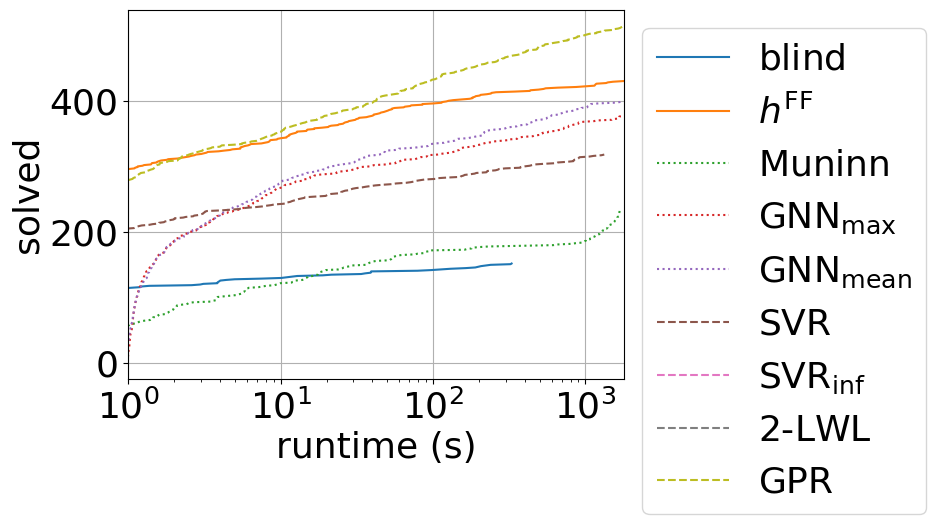

In [206]:
MODELS_TO_SHOW = [
    BLIND,
    HFF,
    MUNINN,
    GOOSE_MAX,
    GOOSE_MEAN,
    SVR_1,
    SVR_inf,
    LWL_2,
    GPR,
    # MQ_GPR,
]

plt.rcParams.update({'font.size': CUM_SIZE})

def ecdf(data):
    sorted_data = np.sort(data)
    y = np.arange(1, len(data) + 1)
    return sorted_data, y

for model in MODELS_TO_SHOW:
    latex_version = LATEX_RENAME[model]
    df = WHOLE_DF.copy()
    df = df[df["model"] == rename(model)]
    df = df[df["solved"] == 1]
    data = df["time"].values
    x, y = ecdf(data)
    plt.plot(x, y, label=latex_version, linestyle=linestyle(model))

# plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.grid(True)
plt.xlim((1, 1800))
plt.xscale("log")
# plt.title("cumulative runtime")
plt.ylabel("solved")
plt.xlabel("runtime (s)")
plt.savefig(f"{_ICAPS_PLOT_DIR}/cumulative_runtime.pdf", bbox_inches="tight")

plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.savefig(f"{_ICAPS_PLOT_DIR}/cumulative_legend.pdf", bbox_inches="tight")

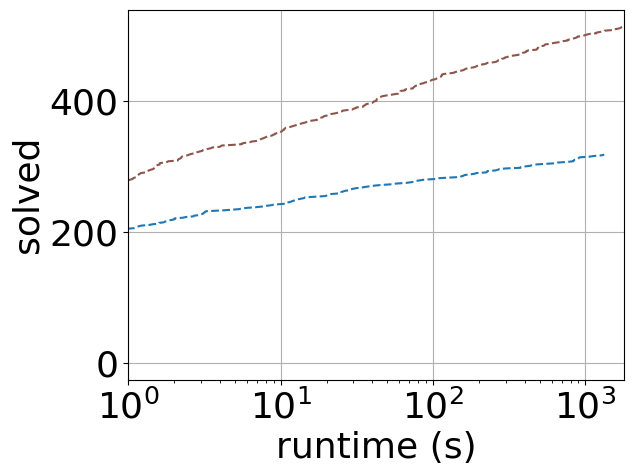

In [207]:
MODELS_TO_SHOW = [
    SVR_1,
    SVR_2,
    SVR_3,
    SVR_inf,
    LWL_2,
    GPR,
]

plt.rcParams.update({'font.size': CUM_SIZE})

def ecdf(data):
    sorted_data = np.sort(data)
    y = np.arange(1, len(data) + 1)
    return sorted_data, y

for model in MODELS_TO_SHOW:
    latex_version = LATEX_RENAME[model]
    df = WHOLE_DF.copy()
    df = df[df["model"] == rename(model)]
    df = df[df["solved"] == 1]
    data = df["time"].values
    x, y = ecdf(data)
    plt.plot(x, y, label=latex_version, linestyle=linestyle(model))

# plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.grid(True)
plt.xlim((1, 1800))
plt.xscale("log")
# plt.title("cumulative runtime")
plt.ylabel("solved")
plt.xlabel("runtime (s)")
plt.savefig(f"{_ICAPS_PLOT_DIR}/cumulative_runtime_sml.pdf", bbox_inches="tight")
plt.show()

### Cumulative expanded

In [ ]:
exp_df = WHOLE_DF.copy()
exp_df["expanded"] = exp_df["expanded"] * exp_df["solved"]
fig = px.ecdf(
    exp_df,
    x="expanded",
    y="solved",
    color="model",
    line_dash="model_type",
    ecdfnorm=None,
    log_x=True,
)
fig.show()
fig.write_html("px/cumulative_expanded.html")

#### ICAPS paper version

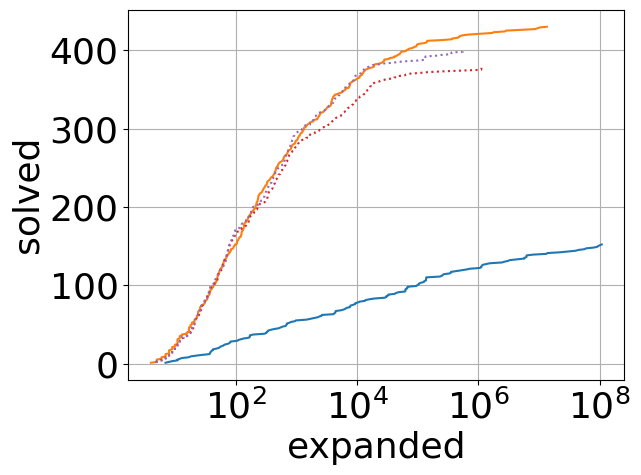

In [ ]:
MODELS_TO_SHOW = [
    BLIND,
    HFF,
    MUNINN,
    GOOSE_MAX,
    GOOSE_MEAN,
    GPR,
    MQ_GPR,
]
plt.rcParams.update({'font.size': CUM_SIZE})

def ecdf(data):
    sorted_data = np.sort(data)
    y = np.arange(1, len(data) + 1)
    return sorted_data, y

for model in MODELS_TO_SHOW:
    latex_version = LATEX_RENAME[model]
    df = WHOLE_DF.copy()
    df = df[df["model"] == rename(model)]
    df = df[df["solved"] == 1]
    data = df["expanded"].values
    x, y = ecdf(data)
    plt.plot(x, y, label=latex_version, linestyle=linestyle(model))

# plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.grid(True)
# plt.xlim((1, 1800))
plt.xscale("log")
# plt.title("cumulative expanded")
plt.ylabel("solved")
plt.xlabel("expanded")
plt.savefig(f"{_ICAPS_PLOT_DIR}/cumulative_expanded.pdf", bbox_inches="tight")
plt.show()

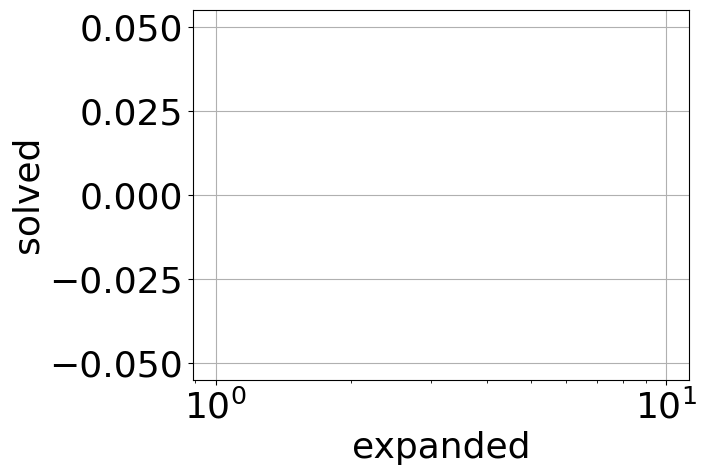

In [ ]:
MODELS_TO_SHOW = [
    SVR_1,
    SVR_2,
    SVR_3,
    SVR_inf,
    LWL_2,
    GPR,
]
plt.rcParams.update({'font.size': CUM_SIZE})

def ecdf(data):
    sorted_data = np.sort(data)
    y = np.arange(1, len(data) + 1)
    return sorted_data, y

for model in MODELS_TO_SHOW:
    latex_version = LATEX_RENAME[model]
    df = WHOLE_DF.copy()
    df = df[df["model"] == rename(model)]
    df = df[df["solved"] == 1]
    data = df["expanded"].values
    x, y = ecdf(data)
    plt.plot(x, y, label=latex_version, linestyle=linestyle(model))

# plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.grid(True)
# plt.xlim((1, 1800))
plt.xscale("log")
# plt.title("cumulative expanded")
plt.ylabel("solved")
plt.xlabel("expanded")
plt.savefig(f"{_ICAPS_PLOT_DIR}/cumulative_expanded_sml.pdf", bbox_inches="tight")
plt.show()

### Bayesian s.t.d. vs other metrics

In [ ]:
df = WHOLE_DF.copy()
df = df[df["model"] == rename(GPR)]
metric = "expanded"
df[metric] = np.where(df["solved"], df[metric], PLOT_MAX_EXPANDED)
fig = px.scatter(
    df, x="std", y=metric, color="domain", symbol="difficulty", log_x=True, log_y=True, range_x=(1e-6, PLOT_MAX_STD), range_y=(1, PLOT_MAX_EXPANDED), hover_data=["problem"]
)
fig.show()
fig.write_html("px/expanded_vs_std.html")

In [ ]:
df = WHOLE_DF.copy()
df = df[df["model"] == rename(GPR)]
df["difference"] = abs(df["first_h"] - df["c_opt_min"])
metric = "difference"
MAX_DIFFERNCE = 2000
df[metric] = np.where(df["solved"], df[metric], MAX_DIFFERNCE)
fig = px.scatter(
    df, x="std", y=metric, color="domain", symbol="difficulty", log_x=True, log_y=True, range_x=(1e-6, PLOT_MAX_STD), range_y=(1, MAX_DIFFERNCE), hover_data=["problem"]
)
fig.show()
fig.write_html("px/difference_vs_std.html")

In [ ]:
df = WHOLE_DF.copy()
df = df[df["model"] == rename(GPR)]
df

,domain,model,model_type,difficulty,problem,time,first_h,solved,std,quality,tried,expanded,ratio_seen_colours,cost,c_opt,c_opt_min
810,blocksworld,gpr,wl,easy,1,-1.0,-1.0,0,-1,0.0,0,-1,-1,-1,10,-1
811,blocksworld,gpr,wl,easy,2,-1.0,-1.0,0,-1,0.0,0,-1,-1,-1,8,-1
812,blocksworld,gpr,wl,easy,3,-1.0,-1.0,0,-1,0.0,0,-1,-1,-1,20,-1
813,blocksworld,gpr,wl,easy,4,-1.0,-1.0,0,-1,0.0,0,-1,-1,-1,24,-1
814,blocksworld,gpr,wl,easy,5,-1.0,-1.0,0,-1,0.0,0,-1,-1,-1,24,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13855,transport,gpr,wl,hard,86,-1.0,-1.0,0,-1,0.0,0,-1,-1,-1,829,-1
13856,transport,gpr,wl,hard,87,-1.0,-1.0,0,-1,0.0,0,-1,-1,-1,1250,-1
13857,transport,gpr,wl,hard,88,-1.0,-1.0,0,-1,0.0,0,-1,-1,-1,887,-1
13858,transport,gpr,wl,hard,89,-1.0,-1.0,0,-1,0.0,0,-1,-1,-1,1070,-1


In [ ]:
df = WHOLE_DF.copy()
df = df[df["model"] == rename(GPR)]
df = df[df["solved"] == 1]
# df["ratio_seen_colours"] = np.tan((np.pi / 2) * df["ratio_seen_colours"])
# df["ratio_seen_colours"] = 1 / (1 - df["ratio_seen_colours"])
df["std"] = np.log(df["std"])
metric = "ratio_seen_colours"
min_metric = 1e-1
max_metric = 1e3
fig = px.scatter(
    df,
    x="std",
    y=metric,
    color="domain",
    symbol="difficulty",
    log_x=True,
    # log_y=True,
    log_y=False,
    range_x=(1, np.log(PLOT_MAX_STD)),
    # range_x=(1e-6, PLOT_MAX_STD),
    range_y=(0, 1),
    # range_y=(min_metric, max_metric),
    hover_data=["problem"],
)
fig.show()
fig.write_html("px/ratio_vs_std.html")

In [ ]:
df = WHOLE_DF.copy()
df = df[df["model"] == rename(GPR)]
df = df[df["solved"] == 1]
# df["ratio_seen_colours"] = np.tan((np.pi / 2) * df["ratio_seen_colours"])
df["ratio_seen_colours"] = 1 - df["ratio_seen_colours"]
datas = {}
for metric in ["c_opt_min", "expanded", "ratio_seen_colours"]:
    d = {"domain":[],"easy":[],"medium":[],"hard":[]}
    all_x = {k:[] for k in DIFFICULTIES}
    all_y = {k:[] for k in DIFFICULTIES}
    for domain in IPC2023_LEARNING_DOMAINS:
        d["domain"].append(domain)
        df_domain = df[df["domain"] == domain]
        for difficulty in DIFFICULTIES:
            df_diff = df_domain[df_domain["difficulty"] == difficulty]
            x = df_diff["std"].values
            y = df_diff[metric].values
            # if metric == "ratio_seen_colours":
            #     x = np.log(x)
            all_x[difficulty].append(x)
            all_y[difficulty].append(y)
            if len(x) < 5:
                coef = 0
                pvalue = 0
                size = 0
                d[difficulty].append('na')
            else:
                result = scipy.stats.pearsonr(x, y)
                coef = result.statistic
                pvalue = int(result.pvalue < 0.05)
                size = len(x)
                d[difficulty].append((coef, pvalue, size))
    
    d["domain"].append("all")
    for difficulty in DIFFICULTIES:
        x = np.hstack(all_x[difficulty])
        y = np.hstack(all_y[difficulty])
        result = scipy.stats.pearsonr(x, y)
        coef = result.statistic
        pvalue = int(result.pvalue < 0.05)
        size = len(x)
        d[difficulty].append((coef, pvalue, size))
    
    exp_corr_df = pd.DataFrame(d)
    datas[metric] = exp_corr_df.values
    # display(exp_corr_df)


ret = ""
for i, domain in enumerate(IPC2023_LEARNING_DOMAINS):
# for i, domain in enumerate(IPC2023_LEARNING_DOMAINS + ["all"]):
    if domain != "all":
        ret += domain
    else:
        ret += r"\emph{all}"
    for data in datas.values():
        for j in range(1, 4):
            entry = data[i][j]
            if entry == "na":
                to_add = r"\multicolumn{1}{c}{-}"
            else:
                coef = entry[0]
                coef = f"{coef:.2f}"
                # coef = coef.replace("1.0", "1.")
                # coef = coef.replace("0.", ".")
                if entry[0] > 0:
                    coef = f"+{coef}"
                if abs(entry[0]) >= 0.5:
                    coef = r"\highcorr{" + coef + r"}"
                elif abs(entry[0]) >= 0.3:
                    coef = r"\medcorr{" + coef + r"}"
                else:
                    coef = r"\lowcorr{" + coef + r"}"
                if entry[1]:
                    to_add = r"\significant{" + coef + r"}"
                else:
                    to_add = r"\notsignificant{" + coef + r"}"

            ret += " & " + to_add
    ret += r"\\" + '\n'
    # if domain == IPC2023_LEARNING_DOMAINS[-1]:
    #     ret += r"\midrule" + '\n'
ret += r"\bottomrule" + "\n"

with open(f"{_ICAPS_PAPER_DIR}/tables/correlation.tex", "w") as f:
    f.write(ret)

ValueError: x and y must have length at least 2.

### Hit WL colours

In [ ]:
ret = {"domain": [], "model": [], "problem": [], "ratio": [], "itr": []}

ITRS = 4
for model, domain in product(WLS, IPC2023_LEARNING_DOMAINS):
    for diff_i, difficulty in enumerate(DIFFICULTIES):
        for prob_i, pf_name in enumerate(PROBLEM_INDICES):
            pf = f"../benchmarks/ipc2023-learning-benchmarks/{domain}/testing/{difficulty}/{pf_name}.pddl"
            assert os.path.exists(pf)
            desc = model
            log_file = f"icaps24_test_logs/{domain}_{difficulty}_{pf_name}_ilg_{desc}_H.log"

            if not os.path.exists(log_file):
                continue

            tmp = {}

            for line in open(log_file, "r").readlines():

                if "seen/unseen colours in itr" in line:
                    line = line.replace(":", "")
                    toks = line.split()
                    itr = int(toks[-3])
                    seen = int(toks[-2])
                    unseen = int(toks[-1])
                    ratio = seen / (seen + unseen)
                    tmp[itr] = ratio
                
            if len(tmp) == ITRS:
                for itr, ratio in tmp.items():
                    ret["domain"].append(domain)
                    ret["model"].append(rename(model))
                    ret["problem"].append(30 * diff_i + prob_i)
                    ret["ratio"].append(ratio)
                    ret["itr"].append(itr+1)

RATIO_DF = pd.DataFrame(data=ret)

In [ ]:
def plot_ratio(model):
    save_dir = f"px/ratio"
    os.makedirs(save_dir, exist_ok=True)
    model = rename(model)

    df = RATIO_DF.copy()
    df = df[df['model']==model]
    for domain in IPC2023_LEARNING_DOMAINS:
        df_domain = df[df['domain'] == domain]
        fig = px.scatter(df_domain, x="problem", y="ratio", title=f"{model}_{domain}", color="itr", range_y=(0, 1), range_x=(0, 90))
        
        # fig.show()
        fig.write_html(f"{save_dir}/{model}_{domain}.html")
        plt.clf()

In [ ]:
plot_ratio(model=SVR_1)
plot_ratio(model=SVR_2)
plot_ratio(model=SVR_3)
plot_ratio(model=SVR_inf)

<Figure size 640x480 with 0 Axes>

## More refined data

In [ ]:
def get_metrics_df(data, models=None):
  d = {
    "config": [],
    "quality": [],
    "solved": [],
    "tried": [],
    "e_quality": [],
    "e_solved": [],
    "e_tried": [],
    "m_quality": [],
    "m_solved": [],
    "m_tried": [],
    "h_quality": [],
    "h_solved": [],
    "h_tried": [],
  }
  if models is None:
    models = _MODELS
  for config in models:
    d["config"].append(config)
    d["quality"].append(sum(data[config]["quality"]))
    d["solved"].append(sum(data[config]["solved"]))
    d["tried"].append(len(data[config]["solved"]))
    for difficulty in DIFFICULTIES:
      quality = 0
      solved = 0
      tried = 0
      for i, prob_solved in enumerate(data[config]["solved"]):
        if data[config]["difficulty"][i] == difficulty:
          quality += data[config]["quality"][i]
          solved += prob_solved
          tried += data[config]["tried"][i]
      d[f"{difficulty[0]}_quality"].append(quality)
      d[f"{difficulty[0]}_solved"].append(solved)
      d[f"{difficulty[0]}_tried"].append(tried)
  return pd.DataFrame(d)

In [ ]:
# for domain in IPC2023_LEARNING_DOMAINS:
#     print(domain)
#     df = get_metrics_df(get_data(domain))
#     display(df)

# To ICAPS24 latex table

In [ ]:
def convert_map_to_latex_script_input(input):
    ret = {}
    for k, v in input.items():
        ret[rename(k)] = v
    return ret

In [ ]:
def get_icaps_df(metric, models):
    df = WHOLE_DF.copy()
    df = df[df["model"].isin(set(models))]
    df = df.groupby(["model", "domain"]).agg({metric: "sum"}).reset_index()
    df = df.pivot_table(index="domain", columns="model", values=metric, aggfunc="sum", fill_value=0)
    column_order = models
    df = df[column_order]
    df = df.reset_index()
    df.loc[len(df)] = df.select_dtypes(include='number').sum()
    df = df.fillna("sum")
    return df

In [ ]:
def display_tex_score(score, sorted_values, isfloat, comparison_score, last_row):
    def to_string(val):
        if isfloat:
            return f"{val:.1f}"
        else:
            return f"{val:d}"

    display_score = to_string(score)
    if score == 0:
        display_score = "-"

    display_comparison_score = ""
    if comparison_score is not None:
        diff = abs(comparison_score - score)
        if comparison_score > score:
            display_comparison_score = f" (-{to_string(diff)})"
        elif comparison_score < score:
            display_comparison_score = f" (+{to_string(diff)})"
        else:
            display_comparison_score = f""  # no change
        # if last_row:
        #     display_comparison_score = display_comparison_score.replace(" ", "")

    if score == sorted_values[0]:
        macro = r"\first"
    elif score == sorted_values[1]:
        macro = r"\second"
    elif score == sorted_values[2]:
        macro = r"\third"
    else:
        macro = r"\normalcell"

    return macro + "{" + display_score + "}" + "{" + display_comparison_score + "}"

In [ ]:
def to_latex(
    version,
    model_dict,
    metric,
    comparison_dict=None,
    to_add="",
    tabularx=False,
):
    """summarised"""
    summarised_models = convert_map_to_latex_script_input(model_dict)

    df = get_icaps_df(metric=metric, models=list(summarised_models.keys()))
    data = df.values

    domain_width = "l"
    model_width = "c"

    if tabularx:
        # domain_width = "X"
        model_width = "X"

        ret = r"\begin{tabularx}{" + tabularx + r"}{"
    else:
        ret = r"\begin{tabular}{"

    ret += domain_width

    ret += " ".join([model_width for _ in range(len(summarised_models))]) + r"} \toprule " + "\n"

    ret += to_add

    ret += "Domain \n"

    for model in summarised_models.values():
        ret += f"& \\header{{\{model.replace('-', '')}}} \n"
    ret += r"\\ \midrule" + "\n"

    model_to_idx = {}
    for i, model in enumerate(model_dict.keys()):
        model_to_idx[model] = i

    comparison_idx = {}
    if comparison_dict is not None:
        for k, v in comparison_dict.items():
            comparison_idx[model_to_idx[k]] = model_to_idx[v]

    for row in data:
        domain = row[0]
        values = row[1:].astype(float)
        if metric == "solved":
            isfloat = False
            values = values.astype(int)
        elif metric == "quality":
            isfloat = True
            values = np.round(values, 1)

        sorted_values = sorted(values, reverse=True)

        ret += f"{domain}\n"

        for idx, score in enumerate(values):
            comparison_score = None
            if idx in comparison_idx:
                comparison_score = values[comparison_idx[idx]]
            ret += f"& {display_tex_score(score, sorted_values, isfloat, comparison_score, last_row=(domain=='sum'))} "
        ret += r"\\ " + "\n"

        if domain == IPC2023_LEARNING_DOMAINS[-1]:
            ret += r"\midrule" + "\n"

    ret += r"\bottomrule"
    if tabularx:
        ret += r"\end{tabularx}"
    else:
        ret += r"\end{tabular}"

    f = open(f"{_ICAPS_PAPER_DIR}/tables/{version}_{metric}.tex", "w")
    f.write(ret)
    f.close()

In [ ]:
version = "new_only"
model_dict = {
    SVR_1: "svrOne",
    SVR_2: "svrTwo",
    SVR_3: "svrThree",
    SVR_inf: "svrInf",
    LWL_2: "lwlTwo",
    # LWL_3: "lwlThree",
    GPR: "gpr",
}
to_add = (
    r"& \multicolumn{4}{c}{kernel} & \multicolumn{1}{c}{WL} & \multicolumn{1}{c}{Bayes.} \\"
    + "\n"
    r"\cmidrule(lr){2-5}" + "\n"
    r"\cmidrule(lr){6-6}" + "\n"
    r"\cmidrule(lr){7-7}" + "\n"
)
to_latex(
    version,
    model_dict,
    metric="solved",
    to_add=to_add,
    tabularx=r"\columnwidth",
)

In [ ]:
version = "relaxed"
model_dict = {
    MIP: "mip",
    SVR_1: "svrOne",
    GPR: "gpr",
    MQ_SVR: "svrMq",
    MQ_GPR: "gprMq",
}
to_add = (
    r"& \multicolumn{3}{c}{single-queue} & \multicolumn{2}{c}{multi-queue} \\"
    + "\n"
    r"\cmidrule(lr){2-4}" + "\n"
    r"\cmidrule(lr){5-6}" + "\n"
)
comparison_dict = {
    MQ_SVR: SVR_1,
    MQ_GPR: GPR,
}
to_latex(
    version,
    model_dict,
    metric="solved",
    comparison_dict=comparison_dict,
    to_add=to_add,
    tabularx=r"\columnwidth",
)

In [ ]:
version = "summarised"
model_dict = {
    BLIND: "blind",
    HFF: "ff",
    MUNINN: "muninn",
    GOOSE_MAX: "gooseMax",
    GOOSE_MEAN: "gooseMean",
    GPR: "gprNew",
    MQ_GPR: "gprMqNew",
}
to_latex(
    version,
    model_dict,
    metric="solved",
    tabularx=r"\half\textwidth",
)
to_latex(
    version,
    model_dict,
    metric="quality",
    tabularx=r"\half\textwidth",
)

# To GenPlan23 latex table

In [ ]:
assert 0

AssertionError: 

In [ ]:
GENPLAN_MODELS = {
    "blind": "blind",
    "hff": "hff",
    "muninn": "muninn",
    "gI4max": "goosemax",
    "gI4mean": "goosemean",
    SVR_1: "wl",
}

In [ ]:
""" coverage_tall.tex and quality_tall.tex """

coverage_i = [5, 8, 11, 2]
quality_i = [4, 7, 10, 1]

for metric, indices in [("coverage", coverage_i), ("quality", quality_i)]:
    nnn = 0
    genplan_models_list = list(GENPLAN_MODELS.keys())
    scores_df = get_table_df(models=genplan_models_list)
    scores = scores_df.to_numpy()
    scores = scores[:,1:]

    ret  = r"\begin{tabular}{" + "c " + " ".join(["p{\coveragewidth}" for _ in range(len(GENPLAN_MODELS))]) + r"} \toprule "
    # ret  = r"\begin{tabular}{" + "c " + " ".join(["c" for _ in range(len(GENPLAN_MODELS))]) + r"} \toprule Domain "
    ret += r" & & & &\multicolumn{3}{c}{GOOSE} \\ \cmidrule(lr){5-7} Domain "

    for model in GENPLAN_MODELS.values():
        ret += f"& \\header{{\{model.replace('-', '')}}} "
    ret += r"\\ \midrule" + '\n'

    all_solved = {
    "easy": np.zeros(len(GENPLAN_MODELS)).astype(float),
    "medium": np.zeros(len(GENPLAN_MODELS)).astype(float),
    "hard": np.zeros(len(GENPLAN_MODELS)).astype(float),
    "all": np.zeros(len(GENPLAN_MODELS)).astype(float),
    }
    all_quality = {
    "easy": np.zeros(len(GENPLAN_MODELS)),
    "medium": np.zeros(len(GENPLAN_MODELS)),
    "hard": np.zeros(len(GENPLAN_MODELS)),
    "all": np.zeros(len(GENPLAN_MODELS)),
    }

    for domain in IPC2023_LEARNING_DOMAINS:
        ret += f"\\multirow{{4}}{{*}}{{{domain}}}"
        data = (get_metrics_df(get_data(domain), models = genplan_models_list).to_numpy())

        # coverage then cost
        solved = {
            "easy": data[:,indices[0]].T,
            "medium": data[:,indices[1]].T,
            "hard": data[:,indices[2]].T,
            "all": data[:,indices[3]].T,
        }

        for difficulty in ["easy", "medium", "hard", "all"]:
            scores_domain = solved[difficulty]
            sorted_scores_domain = sorted(scores_domain, reverse=True)
            all_solved[difficulty] += np.array(scores_domain).astype(float)
            for i in range(len(solved["easy"])):
                chunks = []
                best_score = max(scores_domain)
                score = solved[difficulty][i]
                if metric == "quality":
                    display_score = f"{score:.1f}"
                else:
                    display_score = score
                if score == 0:
                    chunks.append("-")
                elif score==sorted_scores_domain[0]:
                    chunks.append(f"\\first{{{display_score}}}")
                elif score==sorted_scores_domain[1]:
                    chunks.append(f"\\second{{{display_score}}}")
                elif score==sorted_scores_domain[2]:
                    chunks.append(f"\\third{{{display_score}}}")
                else:
                    chunks.append(f"{display_score}")

                chunk = " & ".join(chunks)
                ret += f" & {chunk}"

            if difficulty != "all":
                ret += "\\\\ \n"

        if domain==IPC2023_LEARNING_DOMAINS[-1]:
            ret += "\\\\ \midrule \n"
        else:
            ret += "\\\\ \cmidrule(lr){2-" + str(len(GENPLAN_MODELS)+1) + "} \n"

    ret += f"\\multirow{{4}}{{*}}{{sum}}"

    for difficulty in ["easy", "medium", "hard", "all"]:
        for i in range(len(all_solved["easy"])):
            chunks = []

            scores_domain = all_solved[difficulty]

            sorted_scores_domain = sorted(scores_domain, reverse=True)
            sorted_scores_domain = [round(x, 1) for x in sorted_scores_domain]
            best_score = max(scores_domain)
            score = round(all_solved[difficulty][i], 1)
            if metric == "quality":
                display_score = f"{score:.1f}"
            else:
                display_score = f"{int(score):d}"
            if score == 0:
                chunks.append("-")
            elif score==sorted_scores_domain[0]:
                chunks.append(f"\\first{{{display_score}}}")
            elif score==sorted_scores_domain[1]:
                chunks.append(f"\\second{{{display_score}}}")
            elif score==sorted_scores_domain[2]:
                chunks.append(f"\\third{{{display_score}}}")
            else:
                chunks.append(f"{display_score}")

            chunk = " & ".join(chunks)
            ret += f" & {chunk}"

        if difficulty != "all":
            ret += "\\\\ \n"

    ret += r" \\ \bottomrule\end{tabular}"

    f = open(f"{_GENPLAN_PAPER_DIR}/figures/{metric}_tall.tex", 'w')
    f.write(ret)
    f.close()

In [ ]:
""" condensed versions """

coverage_i = [5, 8, 11, 2]
quality_i = [4, 7, 10, 1]

for metric, indices in [("coverage", coverage_i), ("quality", quality_i)]:
    nnn = 0
    genplan_models_list = list(GENPLAN_MODELS.keys())
    scores_df = get_table_df(models=genplan_models_list)
    scores = scores_df.to_numpy()
    scores = scores[:,1:]

    ret  = r"\begin{tabular}{" + "c " + " ".join(["p{\coveragewidth}" for _ in range(len(GENPLAN_MODELS))]) + r"} \toprule "
    # ret  = r"\begin{tabular}{" + "c " + " ".join(["c" for _ in range(len(GENPLAN_MODELS))]) + r"} \toprule Domain "
    ret += r" & & & &\multicolumn{3}{c}{GOOSE} \\ \cmidrule(lr){5-7} Domain "

    for model in GENPLAN_MODELS.values():
        ret += f"& \\header{{\{model.replace('-', '')}}} "
    ret += r"\\ \midrule" + '\n'

    all_solved = {
    "easy": np.zeros(len(GENPLAN_MODELS)).astype(float),
    "medium": np.zeros(len(GENPLAN_MODELS)).astype(float),
    "hard": np.zeros(len(GENPLAN_MODELS)).astype(float),
    "all": np.zeros(len(GENPLAN_MODELS)).astype(float),
    }
    all_quality = {
    "easy": np.zeros(len(GENPLAN_MODELS)),
    "medium": np.zeros(len(GENPLAN_MODELS)),
    "hard": np.zeros(len(GENPLAN_MODELS)),
    "all": np.zeros(len(GENPLAN_MODELS)),
    }

    for domain in IPC2023_LEARNING_DOMAINS:
        ret += f"{{{domain}}}"
        data = (get_metrics_df(get_data(domain), models = genplan_models_list).to_numpy())

        # coverage then cost
        solved = {
            "easy": data[:,indices[0]].T,
            "medium": data[:,indices[1]].T,
            "hard": data[:,indices[2]].T,
            "all": data[:,indices[3]].T,
        }

        for difficulty in ["easy", "medium", "hard", "all"]:
            scores_domain = solved[difficulty]
            sorted_scores_domain = sorted(scores_domain, reverse=True)
            all_solved[difficulty] += np.array(scores_domain).astype(float)
            for i in range(len(solved["easy"])):
                chunks = []
                best_score = max(scores_domain)
                score = solved[difficulty][i]
                if metric == "quality":
                    display_score = f"{score:.1f}"
                else:
                    display_score = score
                if score == 0:
                    chunks.append("-")
                elif score==sorted_scores_domain[0]:
                    chunks.append(f"\\first{{{display_score}}}")
                elif score==sorted_scores_domain[1]:
                    chunks.append(f"\\second{{{display_score}}}")
                elif score==sorted_scores_domain[2]:
                    chunks.append(f"\\third{{{display_score}}}")
                else:
                    chunks.append(f"{display_score}")

                chunk = " & ".join(chunks)
                if difficulty in {"easy", "medium", "hard"}:
                    continue
                ret += f" & {chunk}"

            # if difficulty != "all":
            #     ret += "\\\\ \n"

        if domain==IPC2023_LEARNING_DOMAINS[-1]:
            ret += "\\\\ \midrule \n"
        else:
            ret += "\\\\ \n"

    ret += f"{{sum}}"

    for difficulty in ["all"]:
        for i in range(len(all_solved["easy"])):
            chunks = []

            scores_domain = all_solved[difficulty]

            sorted_scores_domain = sorted(scores_domain, reverse=True)
            sorted_scores_domain = [round(x, 1) for x in sorted_scores_domain]
            best_score = max(scores_domain)
            score = round(all_solved[difficulty][i], 1)
            if metric == "quality":
                display_score = f"{score:.1f}"
            else:
                display_score = f"{int(score):d}"
            if score == 0:
                chunks.append("-")
            elif score==sorted_scores_domain[0]:
                chunks.append(f"\\first{{{display_score}}}")
            elif score==sorted_scores_domain[1]:
                chunks.append(f"\\second{{{display_score}}}")
            elif score==sorted_scores_domain[2]:
                chunks.append(f"\\third{{{display_score}}}")
            else:
                chunks.append(f"{display_score}")

            chunk = " & ".join(chunks)
            ret += f" & {chunk}"

        if difficulty != "all":
            ret += "\\\\ \n"

    ret += r" \\ \bottomrule\end{tabular}"

    f = open(f"{_GENPLAN_PAPER_DIR}/figures/small_{metric}_tall.tex", 'w')
    f.write(ret)
    f.close()